# Applied Machine Learning: Classification

This notebook was created to predict the likelihood of survival on the infamous Titanic.

This assignment is part of Singapore Polytechnic's `IT8302 - Applied Machine Learning`. 

##  Background
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class. 

## Scope
In this analysis, we'll be using the tools of machine learning to predict which passengers survived the tragedy.

The dataset we're using is from Kaggle: https://www.kaggle.com/c/titanic/data 

# Preamble

In [1]:
# set display to 80% of the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# import libraries
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

## Load Data

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
print(f'Training Set shape:{train_df.shape}')
print(f'Training Set columns: {train_df.columns}')
print()
print(f'Testing Set shape:{test_df.shape}')
print(f'Testing Set columns: {test_df.columns}')

Training Set shape:(891, 12)
Training Set columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Testing Set shape:(418, 11)
Testing Set columns: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


The training set has 891 rows while the testing set has 418 rows.

Notably, the number of columns are different, primarily because the testing set does not have the `Survived` column.

In [5]:
# combine the data
all_dfs_list = [train_df, test_df]

# helper function to combine the datasets
def combine_df(df1, df2):
    return pd.concat([df1, df2]).reset_index(drop=True)

all_dfs = combine_df(train_df, test_df)

# helper function to divide the dataset
def split_df(df, dropcol='Survived'):
    return df.loc[:890], df.loc[891:].drop([dropcol], axis=1)

all_dfs

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
# name our datasets for future reference
train_df.name = 'Training Set'
test_df.name = 'Test Set'
all_dfs.name = 'Full Set'

# Part 1: EDA

## 1.1 Overview

Below are columns we'll see in the training dataset and the data they represent:
- `PassengerId`: the unique id of the row and it doesn't have any effect on target
- `Survived`: is the target variable we'll be predicting
    - 1 = Survived
    - 0 = Not Survived
- `Pclass`: the passenger class which has three unique values 1, 2 or 3
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- `Name`, `Sex` and `Age`: passenger details
- `SibSp`: the number of the passenger's siblings and spouse
- `Parch`: the total number of the passenger's parents and children
- `Ticket`: ticket number of the passenger
- `Fare`: ticket fare
- `Cabin`: the cabin number of the passenger
- `Embarked`: the port of embarkation with 3 unique values:
    - C: Cherbourg
    - Q: Queenstown
    - S: Southampton
    
_Source: [OpenML.org](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active)_

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Looking at the training data, we find that:
- there are 891 samples
- columns with missing values are: `Age`, `Cabin`, ` Embarked`
- survival rate is `0.383838`

## 1.2 Missing Values

In this section, we will tackle the missing values.

In [10]:
# helper function to count no. of missing values in the training and testing datasets columns
def num_missing_cols(df):
    print(df.name)
    for i in df.columns:
        print(f'{i}: {df[i].isnull().sum()}')
    print()
        
for i in all_dfs_list:
    num_missing_cols(i)

Training Set
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2

Test Set
PassengerId: 0
Pclass: 0
Name: 0
Sex: 0
Age: 86
SibSp: 0
Parch: 0
Ticket: 0
Fare: 1
Cabin: 327
Embarked: 0



The columns with missing values are: `Cabin`, `Age`, `Embarked`, and `Fare`.

We'll process them in the coming section.

## 1.2.1 Cabin

The `Cabin` column consists of values starting with an upper case alphabet followed by numbers.

Of the 891 rows in the training set, only 204 have values in the `Cabin` column and the rest are null values.

Since more than 77% of the data is missing in this column, we'll be dropping it.

In [11]:
all_dfs = all_dfs.drop(columns=['Cabin'], axis=1)

## 1.2.2 Age

There are 177 missing values in the training set's `Age` column and 86 missing values in the testing set.

We could use the whole dataset's median to impute it but we find that it would not be the best way. Instead, we'll look at the correlations between `Age` and the other numerical features to determine a more suitable value to impute.

In [12]:
all_dfs.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [13]:
drop_cols = ['Name','Embarked','Ticket','Sex']

# drop the categorical columns
all_dfs.drop(drop_cols, axis=1).corr().abs()['Age'].sort_values(ascending=False)

Age            1.000000
Pclass         0.408106
SibSp          0.243699
Fare           0.178740
Parch          0.150917
Survived       0.077221
PassengerId    0.028814
Name: Age, dtype: float64

It appears that a passenger's cabin class, `Pclass`, has the highest correlation with his/her `Age`. 

We'll then group the median `Age` values according to `Pclass`. But to ensure that we are being appropriately nuanced, we will also use the passengers' `Sex` as the second level in the groupby function.

In [14]:
# change 'Sex' to numerical dtype
all_dfs['Sex'] = all_dfs['Sex'].map({'female':1,
                                     'male':0}).astype(int)

drop_cols = ['Name','Embarked','Ticket']

# create df where all columns are numeric
all_dfs_num = all_dfs.drop(drop_cols, axis=1)

# group columns by `Sex` and `Pclass` and obtain the median age for each group
all_dfs_num.groupby(['Sex', 'Pclass']).median()['Age']

Sex  Pclass
0    1         42.0
     2         29.5
     3         25.0
1    1         36.0
     2         28.0
     3         22.0
Name: Age, dtype: float64

Male passengers in first class had a median age of 42, those in second 29.5, and those in third 25. The median ages for female passengers were lower for all three classes: 36 (first class), 28 (second class), 22, (third class).

We'll now impute the median ages into the missing values, according to `Sex` and `Pclass`.

In [15]:
# change the `Age` column to float dtype
all_dfs['Age'] = all_dfs['Age'].astype(float)

# impute the null values in the `Age` column with the median values of each `Pclass` + `Sex` grouping
all_dfs['Age'] = all_dfs.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

# ensure there are no more null values in the `Age` column
all_dfs['Age'].isnull().sum()

0

## 1.2.3 Embarked

In [16]:
all_dfs[all_dfs['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,NaN


There are 2 passengers with missing values in the `Embarked` feature. One way to treat them is to remove them altogether since they represent just 0.2% of the dataset.

However, out of curiosity, we googled '[Amélie Icard](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html)' and found that she was the maid of other passenger, Martha Evelyn Stone, and that they both boarded the Titanic at Southampton.
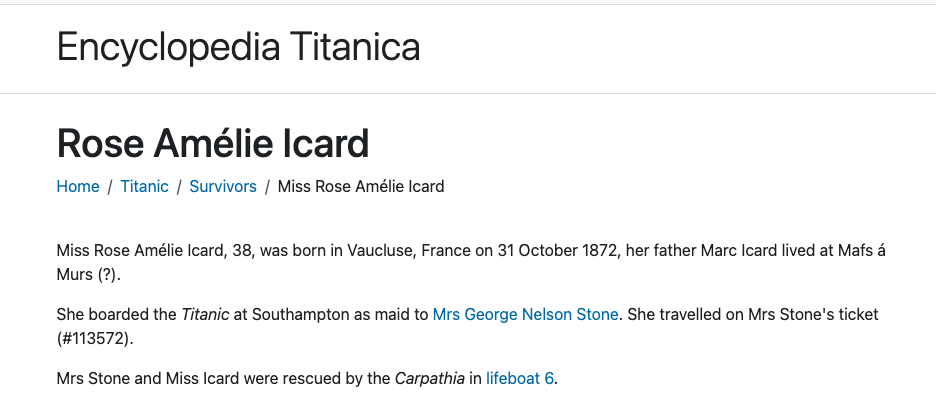

Hence, we will fill the missing values in the `Embarked` column with `S`.

In [17]:
all_dfs['Embarked'] = all_dfs['Embarked'].fillna('S')

# ensure no more null values in the `Embarked` column
print(all_dfs['Embarked'].isnull().sum())

# show value counts for `Embarked` column
all_dfs['Embarked'].value_counts()

0


Embarked
S    916
C    270
Q    123
Name: count, dtype: int64

Now that there is no missing data in the `Embarked` column, we'll now encode the datapoints as numbers:

In [18]:
all_dfs['Embarked'] = all_dfs['Embarked'].map({'S':0, 'C':1, 'Q':2})

## 1.2.4 Fare

In [19]:
all_dfs[all_dfs['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,0


There is only one passenger whose `Fare` value was missing. Since his `SibSp` and `Parch` are zero, we conclude that he was travelling alone. Therefore, we conclude that it would be safe to assign the median value of passengers with similar characteristics.

In [20]:
criteria_1 = all_dfs['Pclass'] == 3
criteria_2 = all_dfs['Embarked'] == 0
criteria_3 = all_dfs['SibSp'] == 0
criteria_4 = all_dfs['Parch'] == 0

# combine all the criteria
combined_criteria = criteria_1 & criteria_2 & criteria_3 & criteria_4

# filter the dataset based on the combined criteria
filtered_df = all_dfs[combined_criteria]

# obtain the median
fare_median = filtered_df['Fare'].median()
print(fare_median)

7.8958


In [21]:
# apply the median to the row with the missing value
all_dfs['Fare'] = all_dfs['Fare'].fillna(fare_median)

# ensure that there are no more missing values in the `Cabin` column
all_dfs['Fare'].isnull().sum()

0

***

Having gone through the missing values in the `Age`, `Embarked`, `Fare`, and `Deck` columns, our dataset has no more missing features:

In [22]:
all_dfs.drop('Survived', axis=1).isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## 1.3 Visualizing the Survival Rate

In [23]:
# update train_df and test_df
train_df, test_df = all_dfs.loc[:890], all_dfs.loc[891:].drop(['Survived'], axis=1)

In [24]:
print(train_df['Survived'].value_counts())
print()
print(f"Did Not Survive: {round(train_df['Survived'].value_counts()[0] / len(train_df['Survived']),3)*100}%")
print(f"Survived: {round(train_df['Survived'].value_counts()[1] / len(train_df['Survived']),3)*100}%")

Survived
0.0    549
1.0    342
Name: count, dtype: int64

Did Not Survive: 61.6%
Survived: 38.4%


<Axes: xlabel='Survived'>

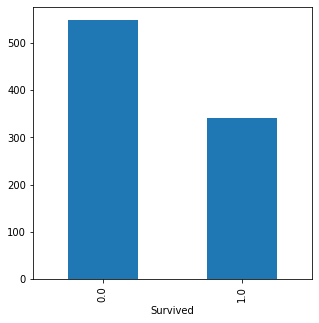

In [25]:
# visualize survival rate by 'Sex'
plt.figure(figsize=(5,5))
train_df['Survived'].value_counts().plot(kind='bar')

Of the 891 passengers in the training set, 549 of them (61.6% of total) did not survive.

## 1.3.1 Numerical Features

In [26]:
drop_cols = ['PassengerId','Name', 'Ticket']

train_df_num = train_df.drop(drop_cols, axis=1)

train_df_num.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,0.543351,-0.058635,-0.035322,0.081629,0.257307,0.106811
Pclass,-0.338481,1.000000,-0.131900,-0.417667,0.083081,0.018443,-0.549500,0.045702
Sex,0.543351,-0.131900,1.000000,-0.101354,0.114631,0.245489,0.182333,0.116569
Age,-0.058635,-0.417667,-0.101354,1.000000,-0.249747,-0.176733,0.124061,-0.053893
SibSp,-0.035322,0.083081,0.114631,-0.249747,1.000000,0.414838,0.159651,-0.059961
Parch,0.081629,0.018443,0.245489,-0.176733,0.414838,1.000000,0.216225,-0.078665
Fare,0.257307,-0.549500,0.182333,0.124061,0.159651,0.216225,1.000000,0.062142
Embarked,0.106811,0.045702,0.116569,-0.053893,-0.059961,-0.078665,0.062142,1.000000


Visualizing it with a heatmap is much easier as the correlations are color coded:

Text(0.5, 1.0, 'Training Set Correlations')

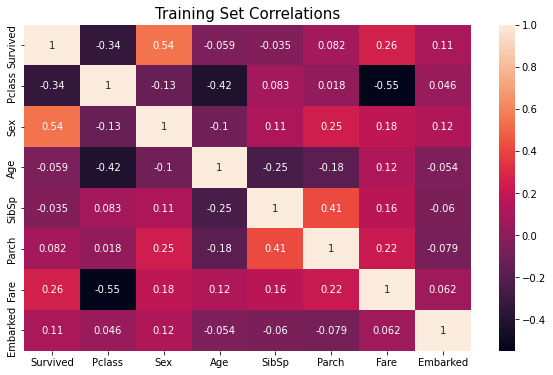

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(train_df_num.corr(), annot=True)
plt.title('Training Set Correlations', size=15)

The numerical features with relatively higher absolute correlations were `Sex`, `Pclass`, and `Fare`. Of these four, `Sex` had the highest correlation of 0.54. For the other two features, they had high correlations with each other - and naturally so, since they related to the location of the passengers' accomodation on the ship.

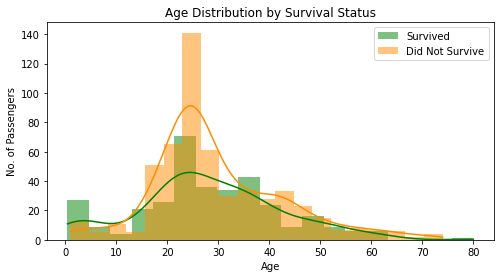

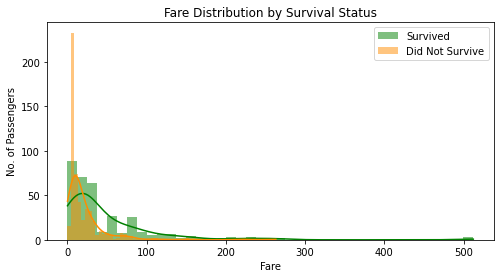

In [28]:
def survival_dist(df, feature, survived_mask, colors, labels, xlabel, ylabel, title):
    plt.figure(figsize=(8, 4))
    
    # plot the distribution for survived passengers
    sns.histplot(df[survived_mask][feature], color=colors[0], edgecolor=None, label=labels[0], kde=True)
    
    # plot the distribution for passengers who didn't survive
    sns.histplot(df[~survived_mask][feature], color=colors[1], edgecolor=None, label=labels[1], kde=True)
    
    # add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    
    plt.show()

# parameters
num_features = ['Age', 'Fare']
survived_mask = train_df['Survived'] == 1
colors = ['green', 'darkorange']
labels = ['Survived', 'Did Not Survive']
ylabel = 'No. of Passengers'

# plot age distribution
survival_dist(train_df, 'Age', survived_mask, colors, labels,
                  xlabel='Age', ylabel=ylabel, title='Age Distribution by Survival Status')

# plot fare distribution
survival_dist(train_df, 'Fare', survived_mask, colors, labels,
                  xlabel='Fare', ylabel=ylabel, title='Fare Distribution by Survival Status')

**Age**

Notably, passengers in the mid-20s had a higher chance of perishing compared to the other groups. On the other hand, those below 15 years old had the highest survival likelihood relative to other age groups.

**Fare**

The distribution of passengers who did not surve had a lower average fare price, as seen in the orange KDE (kernel density estimate) plot, compared to those who survived. This aligns with what we've seen above - passengers with `Pclass` 1 or 2 were likelier to survive.

## 1.3.2 Categorical Features

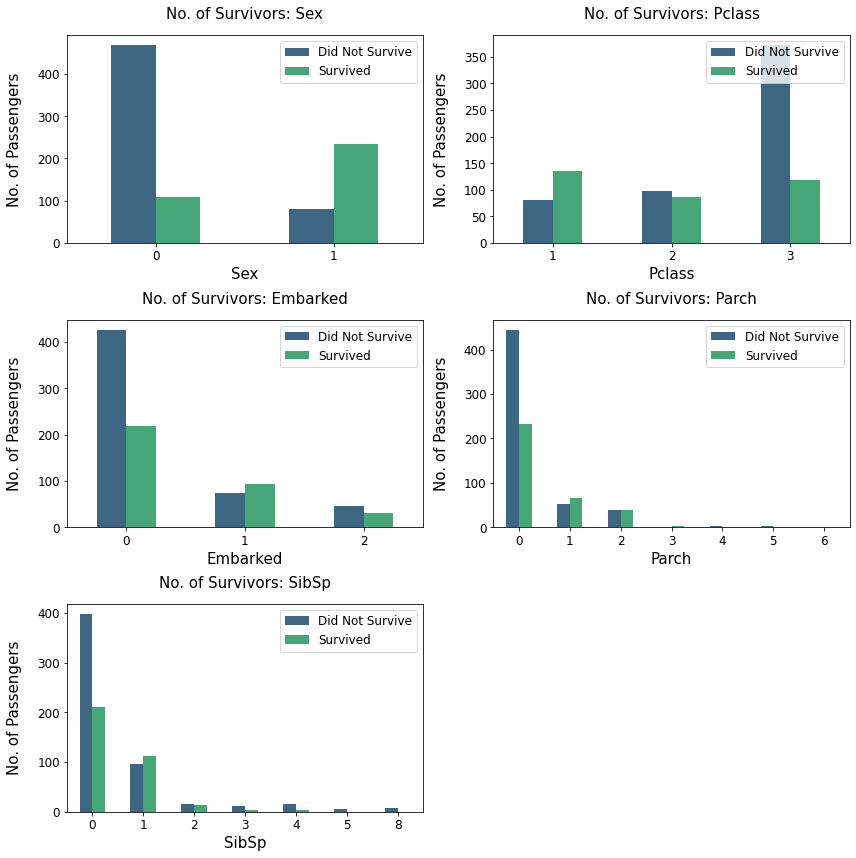

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_features = ['Sex', 'Pclass', 'Embarked', 'Parch', 'SibSp']

# create the figure and axes
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12, 12))

# use hspace and wspace parameters to tweak spacing
plt.subplots_adjust(right=0.9, top=0.9, hspace=0.4, wspace=0.4)  

# convert the 2D array of axes (subplots) into a 1D array
axs = axs.flatten()

# plot each categorical feature
for i, feature in enumerate(cat_features):
    sns.countplot(x=feature, hue='Survived', data=train_df, ax=axs[i], palette='viridis', width=0.5)
    
    axs[i].set_xlabel(f'{feature}', size=15)
    axs[i].set_ylabel("No. of Passengers", size=15, labelpad=15)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    
    axs[i].legend(['Did Not Survive', 'Survived'], loc='upper right', prop={'size': 12})
    axs[i].set_title(f'No. of Survivors: {feature}', size=15, y=1.05)

# hide the last subplot
fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

Below are the survival rates for each categorical feature:

In [30]:
for i in cat_features:
    print(round(train_df[survived_mask][i].value_counts() / train_df[i].value_counts(),2))
    print()

Sex
0    0.19
1    0.74
Name: count, dtype: float64

Pclass
1    0.63
2    0.47
3    0.24
Name: count, dtype: float64

Embarked
0    0.34
1    0.55
2    0.39
Name: count, dtype: float64

Parch
0    0.34
1    0.55
2    0.50
3    0.60
4     NaN
5    0.20
6     NaN
Name: count, dtype: float64

SibSp
0    0.35
1    0.54
2    0.46
3    0.25
4    0.17
5     NaN
8     NaN
Name: count, dtype: float64



### Observations on categorical features
`Sex`: Females were more likely to survive compared to males.

`Pclass`: Passengers in the third class were more likely to perish than passengers in the first two classes.

`Embarked`: We transformed this column to be numeric; 'Southampton' was mapped to 0, 'Cherbourg' mapped to 1 and 'Queenstown' mapped to 2. Passengers that boarded at Southampton and Queenstown had higher likelihoods of perishing as most of them had a `Pclass` of 3.

`Parch` and `SibSp`: The majority of those who did not survive were lone travellers.

Focusing on the survival rates for the different sexes, females had a much higher survival rate (74%) than males (19%).

We also see that men in the first class had markedly higher survival rates (63%) than men in the second (47%) and third (24%) classes. Similarly, women in the third class had notably lower survival rates relative to their couterparts in the first and second classes.

Having said that, women in the third class still had a higher survival rates than men in the first class:

In [31]:
# helper function to plot survival rates by selected feature
def survive_catplot(x, col, hue, aspect=0.6, palette='flare', x_rotation=0):
    g = sns.catplot(data=train_df, kind='bar',
                    x=x, y='Survived',
                    col=col, hue=hue, 
                    height=5, aspect=aspect,
                    palette=palette)
    
    g.set_axis_labels(f'{x}', "Survival Rate")
    g.set_titles(col_template="{col_name}")  # Set titles for each facet using col_template
    plt.subplots_adjust(top=0.85)
    
    # Rotate x-axis labels
    for ax in g.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
    
    # add centered title
    g.fig.suptitle(f'Survival Rates by {col}: {x} ', size=15)  # Set the overall title for the figure
    plt.show()

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)


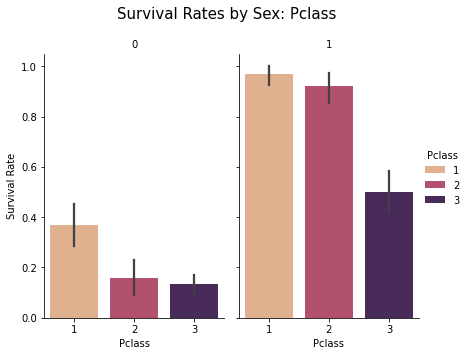

In [32]:
# Plot survival rates by Pclass for each Sex
survive_catplot(x='Pclass', col='Sex', hue='Pclass')

# Part 2: Feature Engineering

In this section, we will be transforming existing features and creating new ones in preparation for our machine learning model.

## 2.1 Continuous Features

### 2.1.1 Fare

As we saw in the correlation heatmap above, a passenger's `Pclass` had a correlation of 0.34 with the survival rate while his/her `Fare` had a 0.26  correlation with surviving. Meanwhile, `Pclass` had a 0.55 correlation with `Fare`, hence we wouldn't be surprised if passengers who paid higher fares were more likely to survive.

We'll be creating a new feature `Fare_bin` where the values in the `Fare` columnn are split into 12 quantiles:

In [33]:
# use pd.qcut to split the Fare_bin column into 12 quantiles
all_dfs['Fare_bin'] = pd.qcut(all_dfs['Fare'], 12)

# split the updated master dataset
train_df, test_df = split_df(all_dfs)

Since the testing set does not have the target variable `Survived`, we'll only plot the data for the training set:

In [34]:
# helper function to plot survival rates for user defined feature
def survival_viz(feature, figsize=(12,6), rotation=90):
    fig, ax = plt.subplots(figsize=figsize) 
    
    sns.countplot(x=feature, hue='Survived', data=train_df, palette="twilight_shifted", ax=ax)
    
    # set xlabel and title
    xlabel = feature
    title = f'No. of Passengers in {feature} Feature'
    
    # format labels
    ax.set_xlabel(xlabel, size=15, labelpad=20)
    ax.set_ylabel('No. of Passengers', size=15, labelpad=20)
    ax.set_title(title, size=15, y=1.05)
    
    # format tick params
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=15)
    
    # set legend
    ax.legend(['Did Not Survive', 'Survived'], loc='upper right', prop={'size': 12})
    
    # rotate x-axis labels by 90 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)

    plt.show()

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/929113258.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


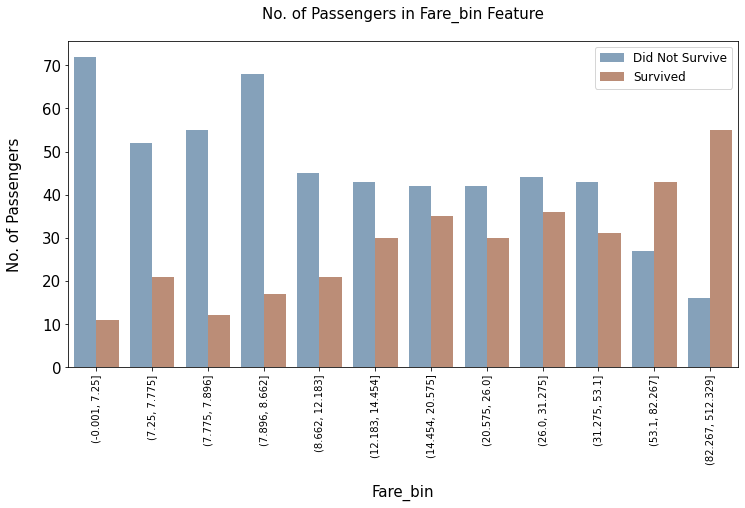

In [35]:
survival_viz(feature='Fare_bin')

Only two fare bands had rates of survival above 50%: (i) 53.1 to 82.267 and (ii) 82.267 to 512.329

The chart below shows the survival rate for each quantile; it confirms the positive correlation between `Fare` and the survival rate that we've observed earlier 

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1985828848.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fare_bin = round(train_df[survived_mask]['Fare_bin'].value_counts() / train_df['Fare_bin'].value_counts(),2)


Fare_bin
(-0.001, 7.25]       0.13
(7.25, 7.775]        0.29
(7.775, 7.896]       0.18
(7.896, 8.662]       0.20
(8.662, 12.183]      0.32
(12.183, 14.454]     0.41
(14.454, 20.575]     0.45
(20.575, 26.0]       0.42
(26.0, 31.275]       0.45
(31.275, 53.1]       0.42
(53.1, 82.267]       0.61
(82.267, 512.329]    0.77
Name: count, dtype: float64


<Axes: xlabel='Fare_bin'>

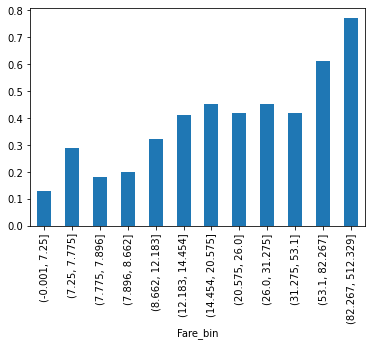

In [36]:
survived_mask = all_dfs['Survived'] == 1

fare_bin = round(train_df[survived_mask]['Fare_bin'].value_counts() / train_df['Fare_bin'].value_counts(),2)
print(fare_bin)
fare_bin.plot(kind='bar')

What we've learned so far is that having paid for a higher fare and being a female meant one was likelier to survive the sinking of the Titanic. Below, we break down the survival rates of each `Fare_bin` according to `Sex`:

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)


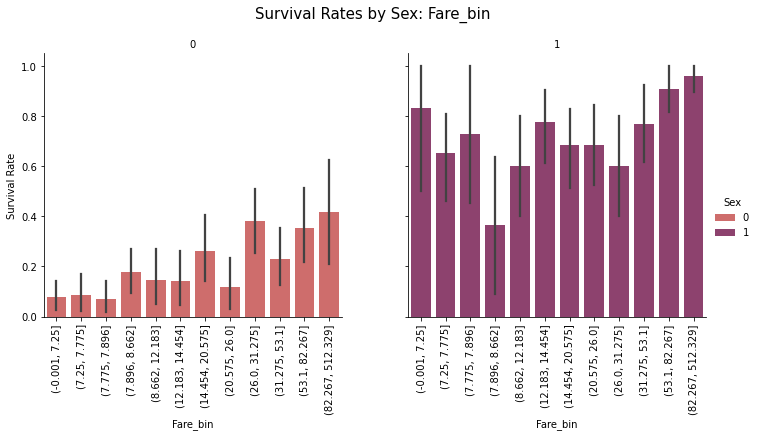

In [37]:
survive_catplot(x='Fare_bin', col='Sex', hue='Sex', aspect=1, x_rotation=90)

As the fares increased, male survivorship increased. However, even after accounting for `Fare_bin`, males still had lower survival rates than females from any `Fare_bin` category.

Interestingly, while males in the lowest `Fare_bin` (7.55 and below) had the lowest survival rates (<10%), their female counterparts had survial rates of more than 70%. 

Although `Fare_bin` gives us some insight into the survival rates, we note that it is probably not as important as the `Pclass` feature given their respective correlation differences relative to the target variable `Survived`.

### 2.1.2 Age

We'll repeat the earlier process for the `Age` feature.

In [38]:
all_dfs['Age_bin'] = pd.qcut(all_dfs['Age'], 12)

train_df, test_df = split_df(all_dfs)

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/929113258.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


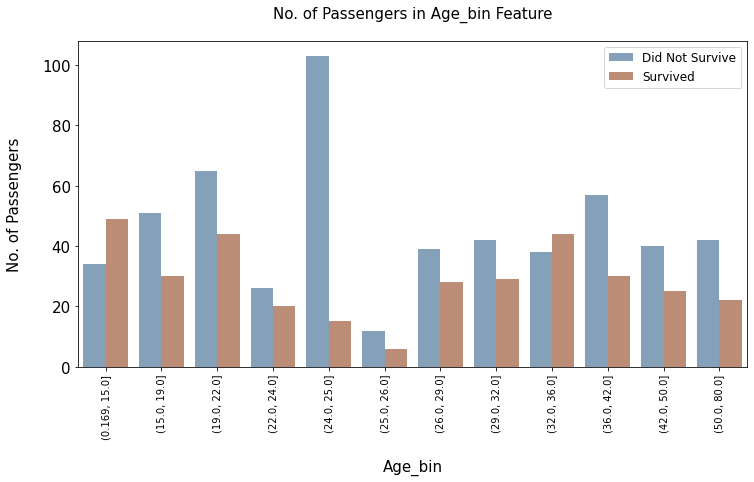

In [39]:
survival_viz(feature='Age_bin')

Across the age groupings, passengers aged 15 and below had the highest survival rates followed by those in the 32 to 36 age group. In stark contrast, those in the 24 to 25 age group had the lowest survival rates. 

Below, we see that the `Age_bin` feature doesn't have much of a positive skew like we saw in `Fare_bin`:

Age_bin
(0.169, 15.0]    0.59
(15.0, 19.0]     0.37
(19.0, 22.0]     0.40
(22.0, 24.0]     0.43
(24.0, 25.0]     0.13
(25.0, 26.0]     0.33
(26.0, 29.0]     0.42
(29.0, 32.0]     0.41
(32.0, 36.0]     0.54
(36.0, 42.0]     0.34
(42.0, 50.0]     0.38
(50.0, 80.0]     0.34
Name: count, dtype: float64


/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1119287379.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  age_bin = round(train_df[survived_mask]['Age_bin'].value_counts() / train_df['Age_bin'].value_counts(),2)


<Axes: xlabel='Age_bin'>

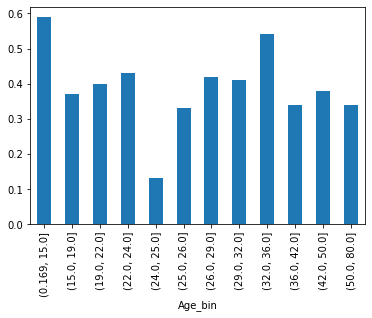

In [40]:
age_bin = round(train_df[survived_mask]['Age_bin'].value_counts() / train_df['Age_bin'].value_counts(),2)
print(age_bin)
age_bin.plot(kind='bar')

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)


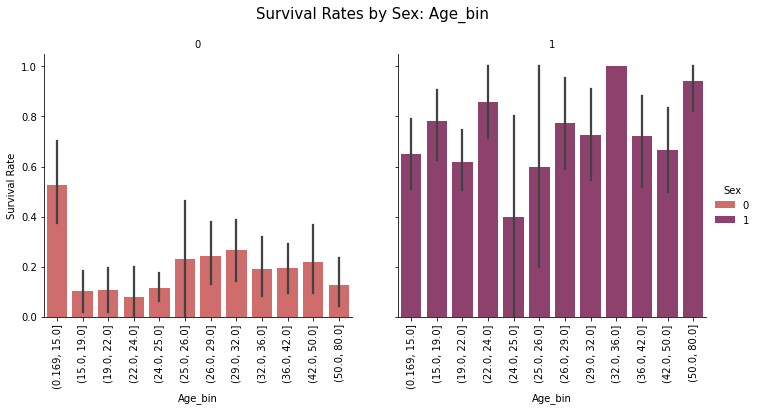

In [41]:
survive_catplot(x='Age_bin', col='Sex', hue='Sex', aspect=1, x_rotation=90)

Generally, female passengers in each age band had much higher survival rates with every group having a more than 50% survival rate.

For male passengers, other than those aged 16 and below, the survival rate was dim.

## 2.2 Family Size

In this section we will create a new feature called `Family_Size` by adding `SibSp`, `Parch` and 1. As we saw in the EDA section, `SibSp` refers to number of siblings and spouses travelling with the passenger and `Parch` refers to the number of parents and children travelling together. We then add them to **1** to include the passenger as well.

Passengers travelling with a `Family_Size` of 1 will be labeled 'Alone', while those with 2 to 4 will be labeled 'Small', and finally those above 4 will be labeled 'Large'.

Family_Size
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: count, dtype: int64


<Axes: xlabel='Family_Size', ylabel='count'>

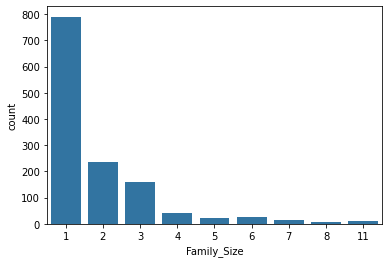

In [42]:
all_dfs['Family_Size'] = all_dfs['SibSp'] + all_dfs['Parch'] + 1

# family size distribution
print(all_dfs['Family_Size'].value_counts())

# visualize the family size distribution
sns.barplot(all_dfs['Family_Size'].value_counts())

In [43]:
family_size_mapping = {1: 'Alone', 2: 'Average', 3: 'Average', 4: 'Average', 5: 'Average', 6: 'Large', 7: 'Large', 8: 'Large', 11: 'Large'}

all_dfs['Family_Size_bin'] = all_dfs['Family_Size'].map(family_size_mapping)

# split the updated master dataset
train_df, test_df = split_df(all_dfs)

# family size bin distribution
print(all_dfs['Family_Size_bin'].value_counts())

Family_Size_bin
Alone      790
Average    459
Large       60
Name: count, dtype: int64


In [44]:
survived_mask = train_df['Survived'] == 1

# family size bin survival rates
round(train_df[survived_mask]['Family_Size_bin'].value_counts() / train_df['Family_Size_bin'].value_counts(),2)

Family_Size_bin
Alone      0.30
Average    0.56
Large      0.15
Name: count, dtype: float64

Passengers that travel alone or had large families had lower survival rates compared to those travelling in small families. Below is a visualization of the distrbution:

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/929113258.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


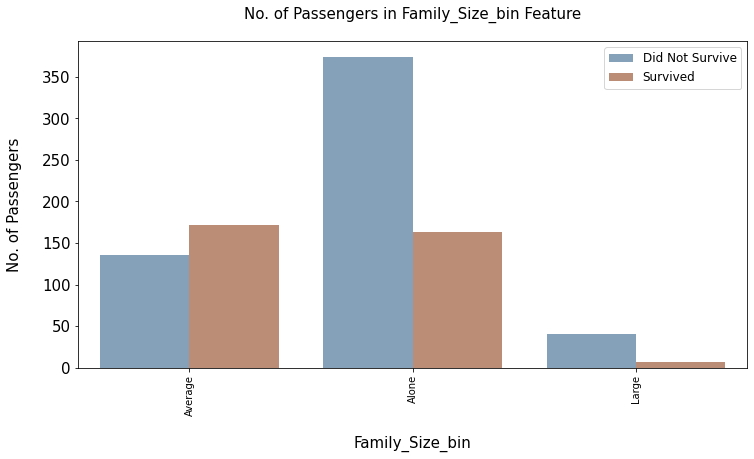

In [45]:
survival_viz(feature='Family_Size_bin')

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/1140848795.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)


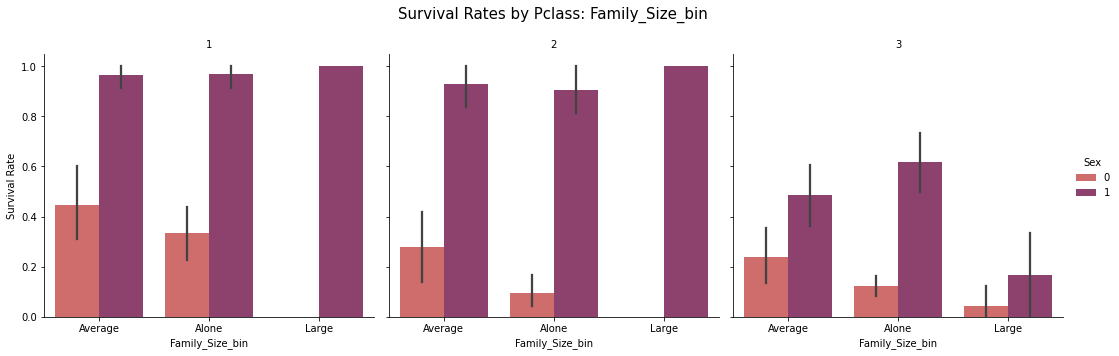

In [46]:
survive_catplot(x='Family_Size_bin', col='Pclass', hue='Sex', aspect=1)

If we broke down the `Family_Size_bin` by the different `Pclass`, we see that for passengers travelling alone or with small famlilies, the higher one's `Pclass`, the higher the survival rates.

For passengers in the large `Family_Size_bin`, the sample size is smaller: there were only 62 passengers out of 891 in the training set of which, of which, 54 were in `Pclass` 3, 2 in the second class, and 6 in the first class. Hence we see the data for that band being more skewed.

In [47]:
train_df[train_df['Family_Size_bin'] == 'Large']['Pclass'].value_counts()

Pclass
3    42
1     4
2     1
Name: count, dtype: int64

### 2.2.1 Family Size - Deeper Dive

To ensure that there are no inconsistencies in the `Family_Size` data, we'll be creating a new feature titled `Last_Name`:

In [48]:
all_dfs['Last_Name'] = all_dfs['Name'].str.extract('([A-Za-z]+)\,')
all_dfs['Last_Name'].value_counts()

Last_Name
Andersson    11
Sage         11
Goodwin       8
Asplund       8
Davies        7
             ..
Milling       1
Maisner       1
Goncalves     1
Campbell      1
Saether       1
Name: count, Length: 872, dtype: int64

There are 872 unique surnames (proxies for families) in the dataset. We see that "Andersson" is the joint most common `Last_Name`:

In [49]:
all_dfs[all_dfs['Last_Name'] == "Andersson"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Fare_bin,Age_bin,Family_Size,Family_Size_bin,Last_Name
13,14,0.0,3,"Andersson, Mr. Anders Johan",0,39.0,1,5,347082,31.2750,0,"(26.0, 31.275]","(36.0, 42.0]",7,Large,Andersson
68,69,1.0,3,"Andersson, Miss. Erna Alexandra",1,17.0,4,2,3101281,7.9250,0,"(7.896, 8.662]","(15.0, 19.0]",7,Large,Andersson
119,120,0.0,3,"Andersson, Miss. Ellis Anna Maria",1,2.0,4,2,347082,31.2750,0,"(26.0, 31.275]","(0.169, 15.0]",7,Large,Andersson
146,147,1.0,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",0,27.0,0,0,350043,7.7958,0,"(7.775, 7.896]","(26.0, 29.0]",1,Alone,Andersson
541,542,0.0,3,"Andersson, Miss. Ingeborg Constanzia",1,9.0,4,2,347082,31.2750,0,"(26.0, 31.275]","(0.169, 15.0]",7,Large,Andersson
542,543,0.0,3,"Andersson, Miss. Sigrid Elisabeth",1,11.0,4,2,347082,31.2750,0,"(26.0, 31.275]","(0.169, 15.0]",7,Large,Andersson
610,611,0.0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",1,39.0,1,5,347082,31.2750,0,"(26.0, 31.275]","(36.0, 42.0]",7,Large,Andersson
813,814,0.0,3,"Andersson, Miss. Ebba Iris Alfrida",1,6.0,4,2,347082,31.2750,0,"(26.0, 31.275]","(0.169, 15.0]",7,Large,Andersson
850,851,0.0,3,"Andersson, Master. Sigvard Harald Elias",0,4.0,4,2,347082,31.2750,0,"(26.0, 31.275]","(0.169, 15.0]",7,Large,Andersson
1105,1106,NaN,3,"Andersson, Miss. Ida Augusta Margareta",1,38.0,4,2,347091,7.7750,0,"(7.25, 7.775]","(36.0, 42.0]",7,Large,Andersson


However, it looks like the `Family_size` does not tally with as `SibSp` and `Parch` could only refer to direct family members. Hence, the `Family_Size` may not be as reliable. For example, passengers surnamed Andersson have a `Family_Size` of 7 or 1, but there are more than 7 passengers with a `Family_Size` that numbers more than 7.

We won't neglect `Family_Size` altogether as we've seen that it does provide useful information - lone travellers have distinctly lower rates of survival. Instead, we will combine several features to come up with a new one to ensure greater accuracy in passengers travelling together. The intuition behind this is that families that travel together will likely leave the boat together or perish together.

We'll combine `Last_Name`, `Pclass`, and `Embarked` as a proxy for passengers belonging to the same family.

In [50]:
# combine features
all_dfs['Last_Name_Pclass_Embarked'] = all_dfs['Last_Name'] + all_dfs['Pclass'].astype(str) + all_dfs['Embarked'].astype(str)

In [51]:
all_dfs['Last_Name_Pclass_Embarked']

0          Braund30
1         Cumings11
2       Heikkinen30
3        Futrelle10
4           Allen30
           ...     
1304      Spector30
1305        Ocana11
1306      Saether30
1307         Ware30
1308        Peter31
Name: Last_Name_Pclass_Embarked, Length: 1309, dtype: object

In [52]:
# split the updated master dataset
train_df, test_df = split_df(all_dfs)

## 2.3 Titles

Next, we'll create a new feature, `Title`. Each passenger's title is captured within the `Name` column.
Since they are strings followed by the full stop `.`, we'll use `str.extract` to identify them:

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64


<Axes: xlabel='Title'>

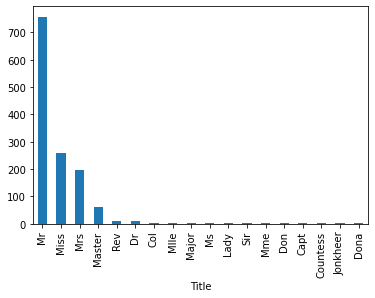

In [53]:
all_dfs['Title'] = all_dfs['Name'].str.extract('([A-Za-z]+)\.', expand=False)

# show unique title values
print(all_dfs['Title'].value_counts())

# plot title distribution
all_dfs['Title'].value_counts().plot(kind='bar')

A few uncommon titles came up: `Mlle`, `Mme`, `Jonkheer`, `Dona`. We've identified the passsengers with these titles for further research:

In [54]:
for i in ['Mlle', 'Mme', 'Jonkheer', 'Dona']:
    print(all_dfs[all_dfs['Title'].str.contains(i)]['Name'])
    print()

641                                Sagesser, Mlle. Emma
710    Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")
Name: Name, dtype: object

369    Aubart, Mme. Leontine Pauline
Name: Name, dtype: object

822    Reuchlin, Jonkheer. John George
Name: Name, dtype: object

1305    Oliva y Ocana, Dona. Fermina
Name: Name, dtype: object



Upon further digging, here are our findings:
- `Mlle`: this is an abbreviation of *[Mademoiselle](https://en.wikipedia.org/wiki/Mademoiselle_(title))*, a french courtesy title; the equivalent of 'Miss' in English.
- `Mme`: this is an abbreviation for *[Madame](https://www.frenchtoday.com/blog/french-culture/madame-or-mademoiselle-a-delicate-question/)*.
- `Jonkheer`: a prefix used for [nobility](https://en.wikipedia.org/wiki/Jonkheer#:~:text=7%20References-,Honorific%20of%20nobility,high%2Dranking%20knight%20or%20nobleman.) in the Netherlands.
- `Dona`: Dona isn't a title but the name of passenger, [Doña Fermina Oliva y Ocana](https://www.encyclopedia-titanica.org/titanic-survivor/fermina-oliva-y-ocana.html), who happened to have a '.' after her first name in the dataset.

In [55]:
all_dfs['Title'].value_counts()

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

To make the titles more generalized, we will group them accordingly:
- `Nobility`: Lady, Countess, Jonkheer, Don, Sir
- `Mrs`: Mrs, Mme
- `Miss`: Miss, Mlle, Ms
- `Mr`: Mr, Master
- `Officer`: Capt, Col, Major, Rev, Dr

Below, we'll create a new feature `Title_bin` to map their titles into one of the specified groups.

In [56]:
all_dfs['Title_bin'] = all_dfs['Title'].map({'Lady':'Nobility', 'Countess':'Nobility', 'Jonkheer':'Nobility', 'Don':'Nobility' ,'Sir':'Nobility', 
                                             'Mrs':'Mrs', 'Mme':'Mrs',
                                             'Miss':'Miss', 'Mlle':'Miss', 'Ms':'Miss',
                                             'Mr':'Mr', 'Master':'Mr',
                                             'Capt':'Officer', 'Col':'Officer', 'Major':'Officer', 'Rev':'Officer', 'Dr':'Officer' })

Title_bin
Mr          818
Miss        264
Mrs         198
Officer      23
Nobility      5
Name: count, dtype: int64


<Axes: xlabel='Title_bin'>

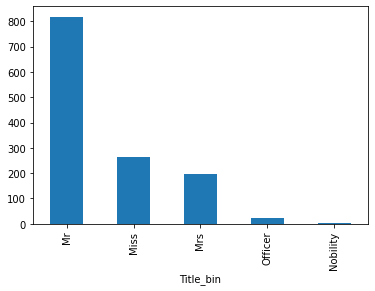

In [57]:
# show unique title values
print(all_dfs['Title_bin'].value_counts())

# plot title distribution
all_dfs['Title_bin'].value_counts().plot(kind='bar')

In [58]:
# split the updated master dataset
train_df, test_df = split_df(all_dfs)

# survival rates by title_bin
round(train_df[survived_mask]['Title_bin'].value_counts() / train_df['Title_bin'].value_counts(),2)

Title_bin
Miss        0.70
Mr          0.19
Mrs         0.79
Nobility    0.60
Officer     0.28
Name: count, dtype: float64

/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_25772/929113258.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)


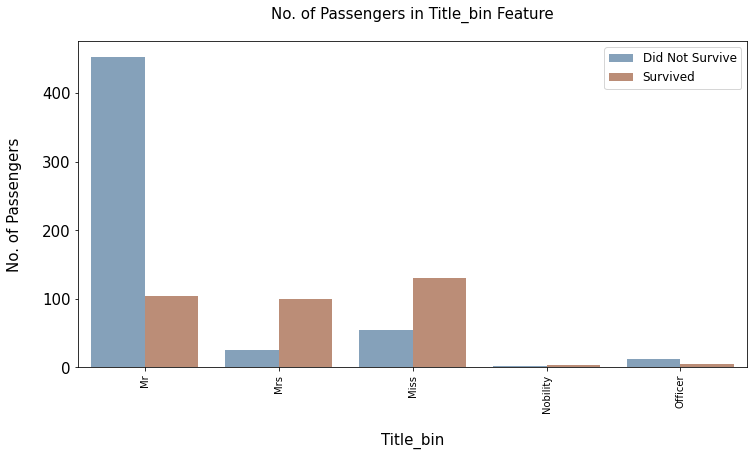

In [59]:
survival_viz(feature='Title_bin')

The survival rates of passengers with `Miss` and `Mrs` titles were 70% and 79% respectively. In contrast, those with `Mr` titles had a survival rate of 19% while those with `Nobility` (60%) and `Officer` (28%) titles had higher survival rates. 

This aligns with what we've seen so far, that `Sex` and `Pclass` positively correlated with survival rates:
- Females were likelier to survive
- Passengers in higher classes were more likely to survive.

## 2.4 Feature Transformation

In this section, we will transform the features using:
- Standard scaling for numeric features: `Age`, `Family_Size`, `Fare`
- Label encoding for non-numeric features: `Embarked`, `Title_bin`, `Family_Size_bin`, `Age_bin`, `Fare_bin`, `Last_Name_Pclass_Embarked`
- One-hot encoding for categorical features: `Pclass`, `Sex`, `Embarked`, `Title_bin`

### 2.4.1 Standard Scaler: Numeric Features

In [60]:
# create an instance of StandardScaler
scaler = StandardScaler()

# fit and transform the specified columns in all_dfs
scaled_features = scaler.fit_transform(all_dfs[['Age', 'Family_Size', 'Fare']])

# replace the original columns with the scaled values
all_dfs[['Age', 'Family_Size', 'Fare']] = scaled_features

The features `Embarked`, `Sex`, `Cabin`, `Title`, `Family_Size_bin` are object data types while `Age_bin` and `Fare_bin` are category data types. We'll be converting them with sklearn's `LabelEncoder` in preparation for our machine learning model.

### 2.4.2 Label Encoding: Non-Numeric Features

In [61]:
non_numeric_features = ['Embarked', 'Title_bin', 'Family_Size_bin', 'Age_bin', 'Fare_bin', 'Last_Name_Pclass_Embarked']

for feature in non_numeric_features:
    all_dfs[feature] = LabelEncoder().fit_transform(all_dfs[feature])

In [62]:
# split the updated master dataset
train_df, test_df = split_df(all_dfs)

### 2.4.3 One-Hot Encoding: Categorical Features

In [63]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title_bin']
encoded_features = []

for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(all_dfs[feature].values.reshape(-1, 1)).toarray()
    n = all_dfs[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = all_dfs.index
    encoded_features.append(encoded_df)
    
# concatenate all encoded features into a single dataframe
encoded_features_df = pd.concat(encoded_features, axis=1)

# concatenate the encoded features with the original dataframe
all_dfs = pd.concat([all_dfs, encoded_features_df], axis=1)

all_dfs.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_bin_1,Title_bin_2,Title_bin_3,Title_bin_4,Title_bin_5,Title_bin_6
0,1,0.0,3,"Braund, Mr. Owen Harris",0,-0.549555,1,0,A/5 21171,-0.503173,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.661353,1,0,PC 17599,0.734810,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,-0.246828,0,0,STON/O2. 3101282,-0.490123,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.434307,1,0,113803,0.383265,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",0,0.434307,0,0,373450,-0.487707,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Next, we drop the columns we won't need for our machine learning model:

In [64]:
drop_cols = ['PassengerId','Pclass','Name','Last_Name','Sex',
             'SibSp', 'Parch', 'Ticket','Fare_bin', 'Embarked',
             'Title', 'Title_bin', 'Age_bin','Family_Size_bin']

all_dfs.drop(columns=drop_cols, inplace=True)

all_dfs.head()

,Survived,Age,Fare,Family_Size,Last_Name_Pclass_Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_bin_1,Title_bin_2,Title_bin_3,Title_bin_4,Title_bin_5,Title_bin_6
0,0.0,-0.549555,-0.503173,0.073352,102,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.661353,0.734810,0.073352,198,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,-0.246828,-0.490123,-0.558346,358,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.434307,0.383265,0.073352,291,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.434307,-0.487707,-0.558346,16,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [65]:
# finalized columns we'll use for  machine learning algorithms
all_dfs.columns

Index(['Survived', 'Age', 'Fare', 'Family_Size', 'Last_Name_Pclass_Embarked',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_1', 'Sex_2', 'Embarked_1',
       'Embarked_2', 'Embarked_3', 'Title_bin_1', 'Title_bin_2', 'Title_bin_3',
       'Title_bin_4', 'Title_bin_5', 'Title_bin_6'],
      dtype='object')

# 3. Model

In this section, we'll train different classifiers on our engineered dataset.

In [66]:
# split the updated master dataset
train_df_model, test_df_model = split_df(all_dfs)

train_df_model.head()

,Survived,Age,Fare,Family_Size,Last_Name_Pclass_Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_bin_1,Title_bin_2,Title_bin_3,Title_bin_4,Title_bin_5,Title_bin_6
0,0.0,-0.549555,-0.503173,0.073352,102,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.661353,0.734810,0.073352,198,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,-0.246828,-0.490123,-0.558346,358,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.434307,0.383265,0.073352,291,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.434307,-0.487707,-0.558346,16,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [67]:
X_train = train_df_model.drop(columns='Survived')
y_train = train_df_model['Survived'].values
X_test = test_df_model

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 18)
y_train shape: (891,)
X_test shape: (418, 18)


The classifiers we will be using the following classifiers and the reasons why we've chosen them:
- `Gaussian Naive Bayes`: it is a simple and efficient algorithm that is computaionally inexpensive, making it a good baseline model
- `Logistic Regression`: it is a linear model that is easy to implement and interpret - works well for binary classification tasks like the current dataset
- `Decision Tree Classifier`: it captures complex relationships between features without requiring feature scaling - can handle both numerical and categorical data effectively.
- `Random Forest Classifier`: an ensemble method that builds multiple decision trees and merges their results to improve accuracy and control overfitting; robust to noisy data and can handle a large number of input features. 
- `Support Vector Classifier`: an effective model that finds the optimal hyperplane to separate classes in a high-dimensional space; the model can provide probability estimates, which are useful for ensemble methods like a voting classifier
- `XGBoost Classifier`: it is a highly efficient and flexible gradient boosting algorithm - often outperforms other classifiers due to its ability to handle missing values, regularization features to reduce overfitting, and efficient use of computational resources.

In [68]:
# initialize classifiers
gnb = GaussianNB()
lr = LogisticRegression(max_iter=2000)
dt = tree.DecisionTreeClassifier(random_state=1)
rf = RandomForestClassifier(random_state=1)
svc = SVC(probability=True)
xgb = XGBClassifier(random_state=1)

Next, we perform cross-validation on a the classifiers and evaluate their performance on the training data (`X_train` and `y_train`) using 5-fold cross-validation. 

For each classifier, we print the cross-validation scores for the 5 folds as well as the mean cross-validation score. This provides us a comprehensive comparison of their predictive performance. Additionally, it helps identify the most effective model based on its average accuracy across the folds:

In [69]:
# perform cross-validation for each classifier and print results
classifiers = [('gnb', gnb), ('lr', lr), ('dt', dt), ('rf', rf), ('svc', svc), ('xgb', xgb)]

for name, clf in classifiers:
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"{name} cross-validation scores: {cv_scores}")
    print(f"{name} mean cross-validation score: {cv_scores.mean()}")
    print()

gnb cross-validation scores: [0.77094972 0.80898876 0.7752809  0.73595506 0.79213483]
gnb mean cross-validation score: 0.7766618542464376

lr cross-validation scores: [0.79888268 0.82022472 0.78651685 0.80898876 0.82022472]
lr mean cross-validation score: 0.8069675475488044

dt cross-validation scores: [0.74860335 0.7752809  0.8258427  0.82022472 0.75842697]
dt mean cross-validation score: 0.7856757265708367

rf cross-validation scores: [0.80446927 0.82022472 0.84269663 0.81460674 0.82022472]
rf mean cross-validation score: 0.8204444165463561

svc cross-validation scores: [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]
svc mean cross-validation score: 0.6161634548992531

xgb cross-validation scores: [0.80446927 0.78089888 0.85393258 0.83146067 0.81460674]
xgb mean cross-validation score: 0.8170736300295023



The `RandomForestClassifier` and `XGBoostClassifier` show the highest mean cross-validation scores, around 82.0% and 81.7%, respectively, indicating their strong predictive performance. In contrast, the SVC model performs similarly to the dummy baseline.

Below we set up a baseline model using the `DummyClassifier` with the strategy of predicting the most frequent class (i.e., the majority class).

In [70]:
# simple baseline: Predict the majority class
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_cv_scores = cross_val_score(dummy_clf, X_train, y_train, cv=5)
print(f"Dummy classifier cross-validation scores: {dummy_cv_scores}")
print(f"Dummy classifier mean cross-validation score: {dummy_cv_scores.mean()}")

Dummy classifier cross-validation scores: [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]
Dummy classifier mean cross-validation score: 0.6161634548992531


We then combine the predictions of the classifiers using `VotingClassifier` and opt for soft voting - which takes into account the predicted probabilities:

In [71]:
# voting classifier
voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('gnb', gnb), ('svc', svc), ('xgb', xgb)], voting='soft')
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5)
print(f"Voting classifier cross-validation scores: {cv_scores}")
print(f"Voting classifier mean cross-validation score: {cv_scores.mean()}")

Voting classifier cross-validation scores: [0.81005587 0.83146067 0.78651685 0.78651685 0.83707865]
Voting classifier mean cross-validation score: 0.8103257799259307


The cross-validation results show a mean score of approximately 80.9%, indicating that the ensemble method performs competitively. However, it does not significantly outperform top-performing models like `RandomForestClassifier` and `XGBoostClassifier`.

Hence, while ensemble methods can provide robustness, the individual classifiers are already performing well on this dataset.

Next, we fit our `VotingClassifier` on the training data and use it to make predictions on the test set.

The variable `y_hat_base_vc` is where we store our predicted results.

In [72]:
# fit the voting classifier and make predictions on X_test
voting_clf.fit(X_train, y_train)
y_hat_base_vc = voting_clf.predict(X_test).astype(int)

# predictions output
print(f"Voting classifier predictions on X_test: {y_hat_base_vc}")

Voting classifier predictions on X_test: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


With the predicted results, we save it into the correct format and submit it to Kaggle:

In [73]:
basic_submission = {'PassengerId': test_df.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

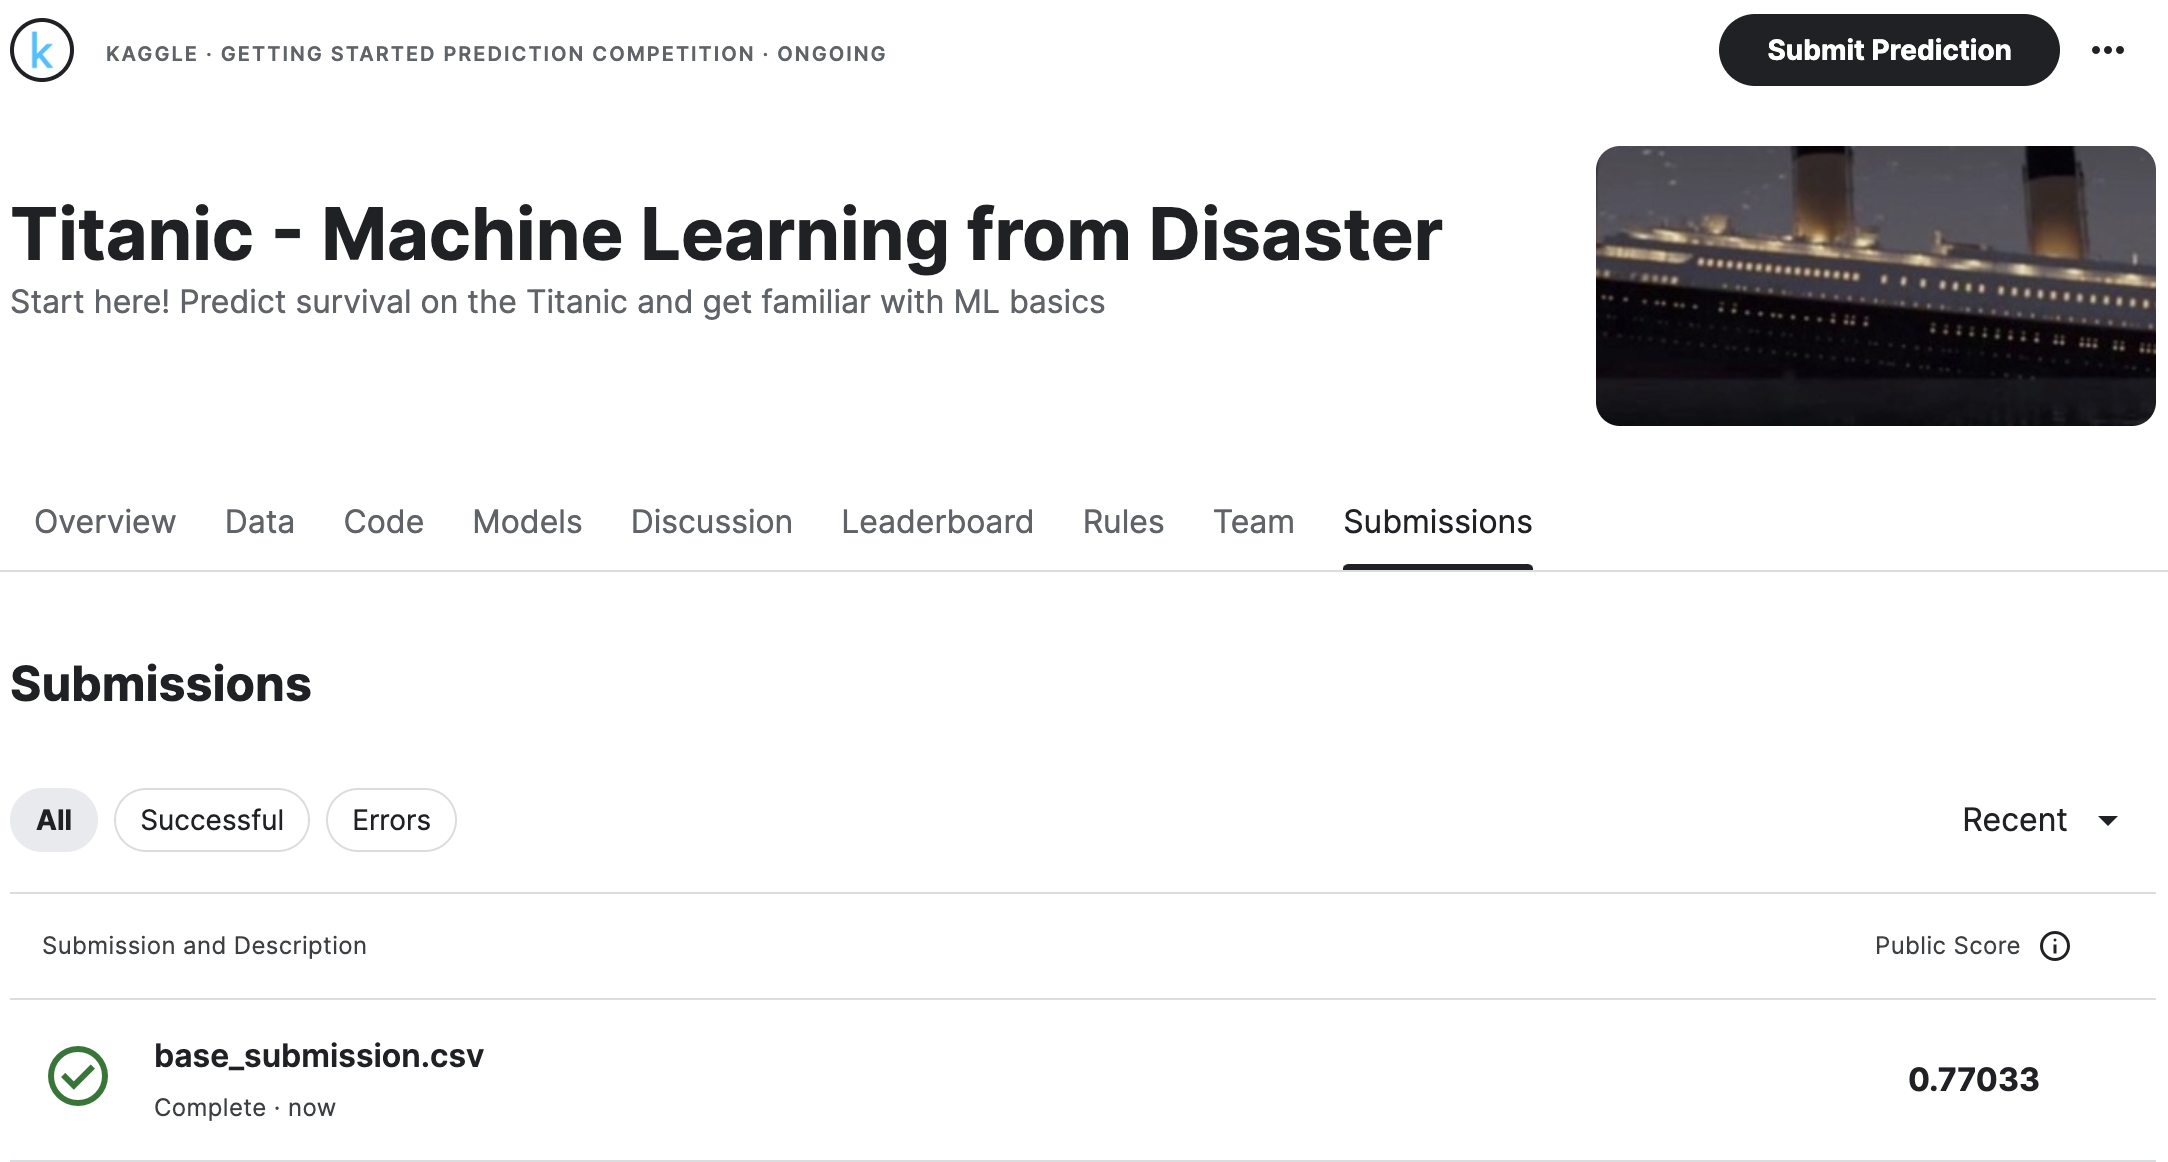

Our result: 77.03%

# 4. Feature Importance

In this section, we will try to find the most important features identified by our classifers.

In [74]:
# fit models to get feature importances
gnb.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
svc.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [75]:
# helper function to plot feature importances
def plot_feature_importances(model, feature_names, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        raise ValueError("Model does not have feature importances or coefficients")

    indices = np.argsort(importances)
    # sort feature names
    sorted_feature_names = [feature_names[i] for i in indices]
    # sort features by importance
    sorted_importances = importances[indices]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances - {title}")
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    plt.xlabel("Feature Importance")
    plt.tight_layout()
    plt.show()

Random Forest feature importances:


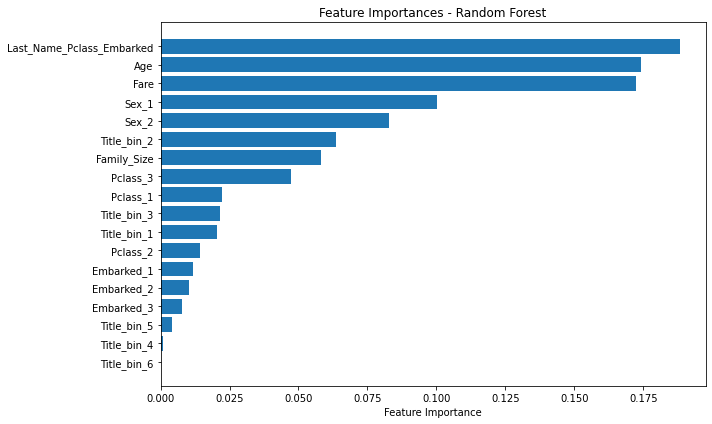

In [76]:
feature_names = train_df_model.drop(columns='Survived').columns

print("Random Forest feature importances:")
plot_feature_importances(rf, feature_names, "Random Forest")

XGBoost feature importances:


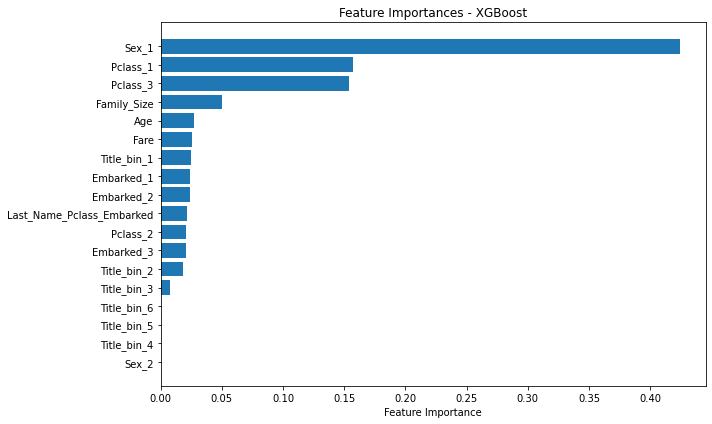

In [77]:
print("XGBoost feature importances:")
plot_feature_importances(xgb, feature_names, "XGBoost")

According to our Random Forest classifier, `Last_Name_Pclass_Embarked`, `Age`, and `Fare` were the most important features.

Meanwhile, for our XGBoost classifier, `Sex_1`, or being female, was the most important feature for survival predictability.

The reason for such a vast discrepancy in conclusions is because the two algorithms handle feature interactions differently:
- Random Forests are ensemble methods that build multiple decision trees and averages their results. Each tree is trained on a bootstrap sample of the data and considers a random subset of features at each split.
    - Feature importance is often calculated based on how much each feature decreases the impurity across all the trees. Hence features with many unique values that create splits which result in pure nodes are given more importance. In the case above, they were `Last_Name_Pclass_Embarked`, `Age`, and `Fare`.
- XGBoost is a gradient boosting algorithm that builds trees sequentially with each tree trying to correct the errors of the previous trees.
    - The more times a feature is used to split the data across all trees, the more important it is. In our visualization above, the algorithm prioritized `Sex_1` over the rest due to its boosting mechanism, which iteratively focused on the most informative features to correct errors.

# 5. Model Tuning

In this section, we will be tuning the hyperparameters of each learning algorithm to hopefully arrive at a more accurate result.
The steps we will be taking for them are:
1. Set parameter grid to be adjusted
2. Create classifier using `GridSearchCV`
3. Perform cross-validation using `cross_val_score`
4. Create dummy classifier for baseline comparison using `DummyClassifier`
5. Create a voting classifier, `VotingClassifier`, that combines the predictions of the specified classifiers using soft voting
6. Fit the voting classifier on the training data
7. Predict on testing set

This time round, because there are different hyperparameters to tune for each classifier, we'll go through them individually instead of using a for-loop.

In [92]:
param_grid_lr = {'C': [0.01, 0.1, 1, 10],
                 'solver': ['liblinear', 'lbfgs']}

grid_lr = GridSearchCV(LogisticRegression(max_iter=2000), param_grid_lr, cv=5)
cv_scores = cross_val_score(grid_lr, X_train, y_train, cv=5)

print(f"Logistic Regression cross-validation scores: {cv_scores}")
print(f"Logistic Regression mean cross-validation score: {cv_scores.mean()}")

Logistic Regression cross-validation scores: [0.80446927 0.80898876 0.78651685 0.80898876 0.81460674]
Logistic Regression  mean cross-validation score: 0.8047140794677045


The hyperparameter tuning for Logistic Regression using `GridSearchCV`, optimizing the `C` parameter for regularization strength and the solver parameter for optimization algorithm, resulted in a mean cross-validation score of 80.5%.

In [93]:
param_grid_dt = {'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10]}

grid_dt = GridSearchCV(tree.DecisionTreeClassifier(random_state=1), param_grid_dt, cv=5)
cv_scores = cross_val_score(grid_dt, X_train, y_train, cv=5)

print(f"Decision Tree cross-validation scores: {cv_scores}")
print(f"Decision Tree mean cross-validation score: {cv_scores.mean()}")

Decision Tree cross-validation scores: [0.75977654 0.78651685 0.83146067 0.8258427  0.76966292]
Decision Tree   mean cross-validation score: 0.7946519364760529


For the Decision Tree, we optimized the `max_depth` for controlling tree depth and `min_samples_split` for the minimum number of samples required to split an internal node.
This resulted in a mean cross-validation score of 79.5%

In [94]:
param_grid_rf = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20]}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid_rf, cv=5)
cv_scores = cross_val_score(grid_rf, X_train, y_train, cv=5)

print(f"Random Forest cross-validation scores: {cv_scores}")
print(f"Random Forest mean cross-validation score: {cv_scores.mean()}")

Random Forest cross-validation scores: [0.79888268 0.79775281 0.85393258 0.79775281 0.8258427 ]
Random Forest mean cross-validation score: 0.8148327160881299


The hyperparameter tuning for the Random Forest algorithm using `GridSearchCV`, optimized the number of estimators `n_estimators` and the maximum tree depth. This gave us a mean cross-validation score of 81.5%.

In [95]:
param_grid_svc = {'C': [0.01, 0.1, 1, 10],
                  'gamma': ['scale', 'auto']}

grid_svc = GridSearchCV(SVC(probability=True), param_grid_svc, cv=5)
cv_scores = cross_val_score(grid_svc, X_train, y_train, cv=5)

print(f"Support Vector Classifier cross-validation scores: {cv_scores}")
print(f"Support Vector Classifier cross-validation score: {cv_scores.mean()}")

Support Vector Classifier cross-validation scores: [0.66480447 0.66292135 0.71910112 0.67977528 0.65168539]
Support Vector Classifier cross-validation score: 0.6756575230682318


For the Support Vector Classifier, we optimized the `C` parameter for regularization strength and `gamma` for the kernel coefficient. This resulted in a mean cross-validation score of 67.6%, indicating moderate predictive performance.

In [96]:
param_grid_xgb = {'n_estimators': [50, 100, 200],
                  'max_depth': [3, 6, 9]}

grid_xgb = GridSearchCV(XGBClassifier(random_state=1), param_grid_xgb, cv=5)
cv_scores = cross_val_score(grid_xgb, X_train, y_train, cv=5)

print(f"XGBoost cross-validation scores: {cv_scores}")
print(f"XGBoost mean cross-validation score: {cv_scores.mean()}")

XGBoost cross-validation scores: [0.80446927 0.78089888 0.88764045 0.79213483 0.84269663]
XGBoost mean cross-validation score: 0.8215680120519743


Finally, for XGBoost we optimized the `n_estimators` and `max_depth` which resulted in a mean cross-validation score of 82.2% - indicating strong predictive performance.

The relatively high and consistent cross-validation scores across folds reflect the model's robustness and effectiveness.

In [97]:
# dummy classifier for baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_cv_scores = cross_val_score(dummy_clf, X_train, y_train, cv=5)
print(f"Dummy classifier cross-validation scores: {dummy_cv_scores}")
print(f"Dummy classifier mean cross-validation score: {dummy_cv_scores.mean()}")

Dummy classifier cross-validation scores: [0.61452514 0.61797753 0.61797753 0.61797753 0.61235955]
Dummy classifier mean cross-validation score: 0.6161634548992531


The Dummy Classifier, which predicts the most frequent class as a baseline, yielded a mean cross-validation score of 61.6%, which is significantly lower than the other models tested.

This poor performance underscores the importance of using more sophisticated models, as the baseline classifier churned out predictions that were only slightly better than random guessing.

In [98]:
# voting Classifier
voting_clf = VotingClassifier(estimators=[('lr', grid_lr), ('rf', grid_rf), ('gnb', gnb), ('svc', grid_svc), ('xgb', grid_xgb)], voting='soft')

# fit the voting classifier with the best hyperparameters from GridSearchCV
voting_clf.fit(X_train, y_train)

# predict on the test set
y_hat_base_vc = voting_clf.predict(X_test).astype(int)
print(f"Voting classifier predictions on X_test: {y_hat_base_vc}")

Voting classifier predictions on X_test: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


Finally, we use the Voting Classifier to combine the predictions of multiple models, each optimized through `GridSearchCV`, and using soft voting to average their predicted probabilities.

In [99]:
tuned_submission = {'PassengerId': test_df.PassengerId, 'Survived': y_hat_base_vc}
tuned_submission = pd.DataFrame(data=tuned_submission)
tuned_submission.to_csv('tuned_submission.csv', index=False)

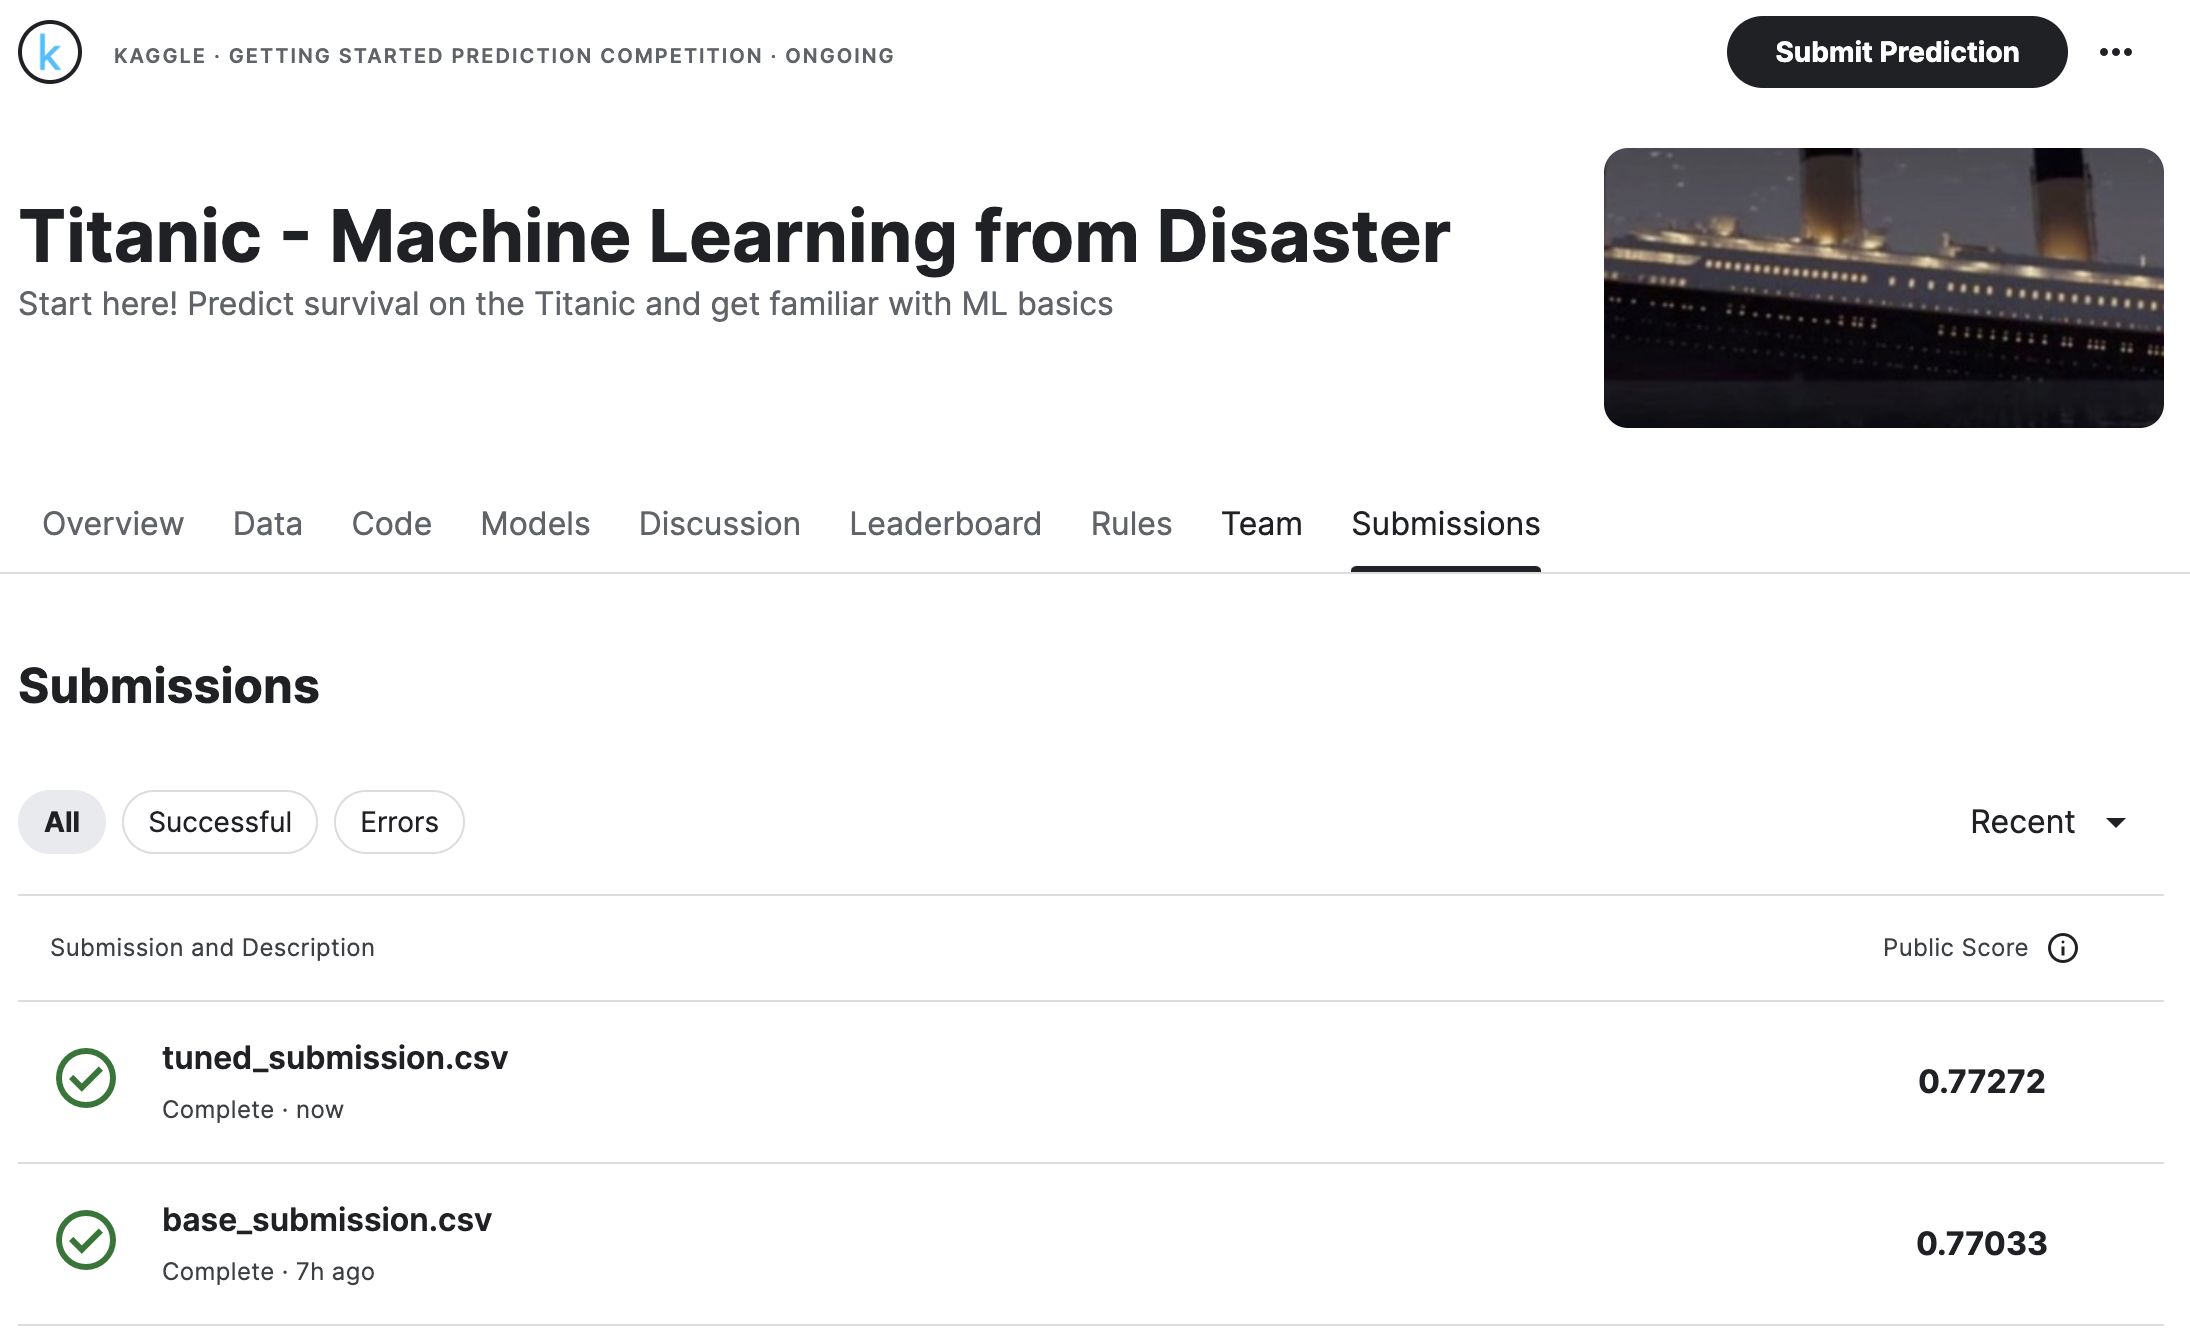

# Conclusion

Despite the individual models being fine-tuned, the ensemble approach only slightly improved the accuracy to 77.27% from the base 77.0%.

This is likely because the individual models already captured much of the predictive power. This marginal gain suggests that while ensemble methods can enhance performance, their impact is more pronounced when the base models are highly diverse or when there's more room for improvement in the individual models.